Install and load all dependencies (first time only) \
NOTE: you may need to restart the runtime afterwards (CTRL+M .).

In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

!pip install gym
!pip install free-mujoco-py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglew-dev is already the newest version (2.0.0-5).
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
libosmesa6-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
software-properties-common is already the newest version (0.96.24.32.18).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
patchelf is already the newest version (0.9-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly ins

Set up the custom Hopper environment



1.   Upload `classes.zip` to the current session's file storage
2.   Un-zip it by running cell below


In [ ]:
!unzip classes.zip

Archive:  classes.zip
replace env/mujoco_env.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: env/mujoco_env.py       
  inflating: env/custom_hopper.py    
  inflating: env/__init__.py         
  inflating: env/__pycache__/custom_hopper.cpython-38.pyc  
  inflating: env/__pycache__/template_renderer.cpython-38.pyc  
  inflating: env/__pycache__/jinja_mujoco_env.cpython-38.pyc  
  inflating: env/__pycache__/random_mass_hopper.cpython-38.pyc  
  inflating: env/__pycache__/__init__.cpython-38.pyc  
  inflating: env/__pycache__/mujoco_env.cpython-38.pyc  
  inflating: env/assets/hopper.xml   
  inflating: agent.py                




---



\

**Train an RL agent on the OpenAI Gym Hopper environment**

\


TODO: implement 2.2.a and 2.2.b

In [ ]:
import torch
import gym
import argparse

from env.custom_hopper import *
from vanilla import Agent, Policy

Compiling /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.pyx
running build_ext
building 'mujoco_py.cymj' extension
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr/local
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr/local/lib
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuexten

TabError: ignored

In [ ]:
n_episodes = 20000
print_every = 2000
device = 'cpu'

In [ ]:
env = gym.make('CustomHopper-source-v0')
# env = gym.make('CustomHopper-target-v0')

print('Action space:', env.action_space)
print('State space:', env.observation_space)
print('Dynamics parameters:', env.get_parameters())

Action space: Box(-1.0, 1.0, (3,), float32)
State space: Box(-inf, inf, (11,), float64)
Dynamics parameters: [2.53429174 3.92699082 2.71433605 5.0893801 ]


First we test the performance of the algorithm using different learning rates values, using just 40000 episodes to see which performs best.

In [ ]:
learning_rates = [1e-2, 1e-3, 1e-4]
lr_rewards = {}
for lr in learning_rates:
  observation_space_dim = env.observation_space.shape[-1]
  action_space_dim = env.action_space.shape[-1]

  policy = Policy(observation_space_dim, action_space_dim)
  agent = Agent(lr, policy, device=device)
  total_rewards = []
  for episode in range(n_episodes):
    done = False
    train_reward = 0
    state = env.reset()  # Reset the environment and observe the initial state
    loss = []
    while not done:  # Loop until the episode is over

      action, action_probabilities = agent.get_action(state)
      previous_state = state

      state, reward, done, info = env.step(action.detach().cpu().numpy())

      agent.store_outcome(previous_state, state, action_probabilities, reward, done)

      train_reward += reward

    loss.append(agent.update_policy())
    total_rewards.append(train_reward)
    agent.empty_outcome()
    
    if (episode+1)%print_every == 0:
      print('Training episode:', episode)
      print('Episode return:', train_reward)

    torch.save(agent.policy.state_dict(), "model_learning_rate_target{0}.mdl".format(lr))
    lr_rewards[lr] = total_rewards

TypeError: ignored

Now we use the value of the learning rate which performed better to train a model with 100000 episodes

In [ ]:
n_episodes = 1000
print_every = 2000
device = 'cpu'

In [ ]:
env = gym.make('CustomHopper-source-v0')
#env = gym.make('CustomHopper-target-v0')

print('Action space:', env.action_space)
print('State space:', env.observation_space)
print('Dynamics parameters:', env.get_parameters())

Action space: Box(-1.0, 1.0, (3,), float32)
State space: Box(-inf, inf, (11,), float64)
Dynamics parameters: [2.53429174 3.92699082 2.71433605 5.0893801 ]


In [ ]:
"""
  Training
"""
observation_space_dim = env.observation_space.shape[-1]
action_space_dim = env.action_space.shape[-1]

policy = Policy(observation_space_dim, action_space_dim)
agent = Agent(1e-4, policy, device=device)
total_rewards = []

for episode in range(n_episodes):
  done = False
  train_reward = 0
  state = env.reset()  # Reset the environment and observe the initial state
  while not done:  # Loop until the episode is over

    action, action_probabilities = agent.get_action(state)
    previous_state = state

    state, reward, done, info = env.step(action.detach().cpu().numpy())

    agent.store_outcome(previous_state, state, action_probabilities, reward, done)

    train_reward += reward

  agent.update_policy()
  total_rewards.append(train_reward)
  agent.empty_outcome()
  
  if (episode+1)%print_every == 0:
    print('Training episode:', episode)
    print('Episode return:', train_reward)


torch.save(agent.policy.state_dict(), "model_learning_rate_1e-4_target.mdl")

NameError: ignored

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

reward_moving_average = []
for i in range(1, len(total_rewards)):
  reward_moving_average.append(sum(total_rewards[:i])/i)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


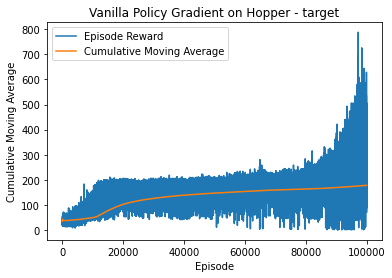

In [ ]:
plt.plot(total_rewards, label = f'Episode Reward')
plt.plot(reward_moving_average, label = f'Cumulative Moving Average')
plt.title(f'Vanilla Policy Gradient on Hopper - target')
plt.xlabel('Episode')
plt.ylabel('Cumulative Moving Average')
plt.legend()
plt.savefig('VPG_target_lr_1e-4_100000_ep.eps', format='eps')
plt.show()

In [ ]:
np.savetxt("target_total_rewards_1e-4.csv",total_rewards, delimiter =" ",  fmt ='% s') 
avg = np.sum(total_rewards)/len(total_rewards)
avg